# A primer on Bayesian analysis

I designed this notebook to give you a primer on Bayesian analysis: how it works, why you should use it, and how it can change your results. To run Bayesian analysis on your data, check out the `multiple_inference.ipynb` file in this folder.

First, when should you use Bayesian analysis? You should use Bayesian analysis when comparing 4 or more "things." For example, you should use Bayesian analysis when you run a study comparing the effects of 4 or more treatments or when studying differences between 4 or more groups of people. (The reason we start at 4 instead of 3 or 5 has to do with the [mathematical underpinnings](https://en.wikipedia.org/wiki/James%E2%80%93Stein_estimator) of Bayesian estimators.)

Throughout this notebook, I'll illustrate the importance of Bayesian estimators with an example from [A megastudy of text-based nudges encouraging patients to get vaccinated at an upcoming doctor's appointment](https://www.pnas.org/content/118/20/e2101165118) published in PNAS. The authors partnered with Penn Medicine to send patients one of 19 text messages encouraging them to get a flu vaccine. Using OLS, the authors reported their average text message increased vaccination rates by 2.1 people per hundred compared to the control group. The top-performing message was twice as effective, increasing vaccination rates by a stunning [4.6 people per hundred](https://twitter.com/katy_milkman/status/1362579547401687040).

Many popular media outlets, including the [Economist](https://www.economist.com/by-invitation/2020/11/30/katy-milkman-on-how-to-nudge-people-to-accept-a-covid-19-vaccine), the [Washington Post](https://www.washingtonpost.com/outlook/2021/05/24/nudges-vaccination-psychology-messaging/), [CNBC](https://www.cnbc.com/2021/06/26/return-to-office-and-vaccines-how-companies-can-drum-up-enthusiasm.html), [NPR](https://www.npr.org/2021/05/26/1000616898/the-science-behind-vaccine-incentives), and [CNN](https://kyma.com/cnn-health/2021/06/29/this-simple-text-message-can-encourage-people-to-get-vaccinated-researchers-say/), point to this research as a remarkable example of how behavioral economics can encourage people to get vaccinated and potentially save lives during the COVID-19 pandemic. As [Fortune](https://fortune.com/2021/02/20/covid-vaccine-rollout-getting-people-vaccinated-vaccination-rates-behavioral-nudge-wharto/) reported,

> What they found was eye-opening. Precisely *how* a message was worded had a huge impact on whether the patient ended up getting the shot.

Researchers continue to speculate about why the top-performing message was more successful than the others.

Let's start by looking at the results reported in PNAS.

In [1]:
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython import display
from sklearn.model_selection import RepeatedStratifiedKFold

from conditional_inference.bayes import Improper, Nonparametric, Normal

np.random.seed(123)
sns.set()

display.Image(url="https://www.pnas.org/cms/10.1073/pnas.2101165118/asset/7d1e1f26-cdcd-4d3a-b2a1-167d9d49c6d9/assets/images/large/pnas.2101165118fig01.jpg")

It's standard for researchers not to post patient health data for privacy reasons. However, we can approximately reproduce the data given what we know about the study. The researchers evenly assigned 47,306 participants to one of 19 treatments or a control condition. The outcome was binary (did the patient get a vaccine or not), and we know the vaccination rate in each treatment from the PNAS publication.

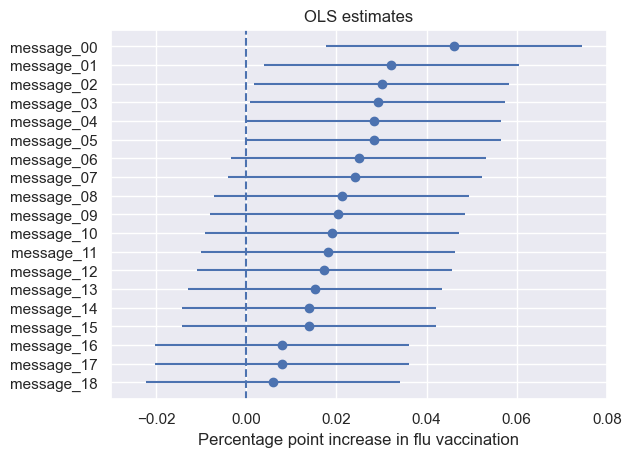

In [2]:
N_PATIENTS = 47306
VACCINATION_RATES = [
    .466,  # top-ranked treatment
    .452,
    .450,
    .449,
    .448,
    .448,
    .445,
    .444,
    .441,
    .440,
    .439,
    .438,
    .437,
    .435,
    .434,
    .434,
    .428,
    .428,
    .426,
    .420,  # control
]
XLABEL = "Percentage point increase in flu vaccination"
XLIM = (-.03, .08)

# reconstruct the dataset
def generate_outcomes(vaccination_rate):
    # create a binary indicator of whether the patient got a vaccine
    n_vaccinations = round(vaccination_rate * n_participants_per_arm)
    return n_vaccinations * [1] + (n_participants_per_arm - n_vaccinations) * [0]

    
n_treatments = len(VACCINATION_RATES)
n_participants_per_arm = round(N_PATIENTS / n_treatments)
df = pd.DataFrame()
df["vaccinated"] = np.array([generate_outcomes(vaccination_rate) for vaccination_rate in VACCINATION_RATES]).flatten()
df["treatment"] = np.repeat([f"message_{format(i, '02')}" for i in range(n_treatments - 1)] + ["control"], n_participants_per_arm)

# perform OLS analysis
X = pd.get_dummies(df.drop(columns="vaccinated"), prefix="", prefix_sep="")
X["control"] = 1  # set the control arm as the constant regressor
results = sm.OLS(df.vaccinated, X).fit().get_robustcov_results()
treatment_coefficients = [col for col in X.columns if col != "control"]
# note that Bayesian analysis with an infinite prior is equivalent to OLS
ols_results = Improper.from_results(results, columns=treatment_coefficients).fit(title="OLS estimates")

# plot the OLS estimates
ols_results_plot = ols_results.point_plot()
ols_results_plot.set_xlabel(XLABEL)
ols_results_plot.axvline(0, linestyle="--")
ols_results_plot.set_xlim(XLIM)
plt.show()

## How does Bayesian analysis work?

In Bayesian analysis, we start with a prior belief. For example, we might expect that each of the treatments we're about to test will increase vaccination rates by 4 percentage points relative to the control condition. Then we collect data and update our belief. [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) is a mathematical formula that tells us how much we should update our prior belief based on the data. The updated belief is called a *posterior*.

Where do we get our prior belief?

Classical Bayes takes the prior as a given. For example, you might have a prior belief based on data from previous studies or a survey of subject matter experts.

However, we can often obtain better estimates by using empirical Bayes to estimate the prior from the data. Estimating the prior using data might sound like a contradiction. By definition, the prior is what you expect *before* seeing any data, so doesn't estimating the prior using data undermine what we're trying to do here?

To understand how empirical Bayes estimates the prior, imagine predicting MLB players' on-base percentage (OBP) next season. We might predict that a player's OBP next season will be the same as his OBP in the previous season. But how can we predict the OBP for a rookie with no batting history? One solution is to predict that the rookie's OBP will be similar to last season's rookies' OBP. In Bayesian terms, we've constructed a prior belief about *next* season's rookies' OBP using data from the *previous* season's rookies' rookies' OBP.

We can apply the same logic to the flu study. Imagine we randomly select one text message and put the data for that treatment in a locked box. What should our prior belief about the effect of this text message be? Empirical Bayes says that our prior belief about the effect of the message we locked in the box should be the average effect of the other 18. We can also use the variability in the effects of the other 18 messages to tell us how confident we should be in our prior, giving us a *prior distribution*.

Empirical Bayes estimators can be parametric or non-parametric. Parametric empirical Bayes assumes the shape of the prior distribution. Nonparametric empirical Bayes does not assume the shape of the prior distribution.

Let's look at the prior from a parametric empirical Bayes estimator assuming a normal prior.

Prior 95% CI: 0.0008151698047983331 0.0416509212802729


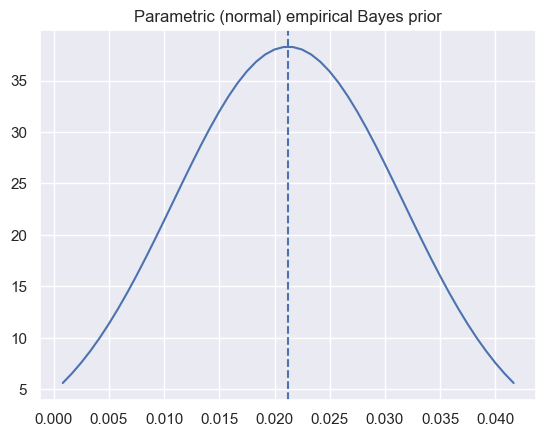

In [3]:
parametric_bayes_model = Normal.from_results(results, columns=treatment_coefficients)
prior = parametric_bayes_model.get_marginal_prior(0)
lower, upper = prior.ppf(.025), prior.ppf(.975)
print("Prior 95% CI:", lower, upper)
x = np.linspace(lower, upper)
ax = sns.lineplot(x=x, y=prior.pdf(x))
ax.axvline(prior.mean(), linestyle="--")
ax.set_title("Parametric (normal) empirical Bayes prior")
xlim = ax.get_xlim()
plt.show()

According to the parametric empirical Bayes prior, there's a 95% chance that each text message increases vaccination rates by between 0 and 4.2 people per hundred.

Now let's look at the prior from a nonparametric empirical Bayes estimator.

Prior 95% CI: 0.019077726578352154 0.023207707577276984


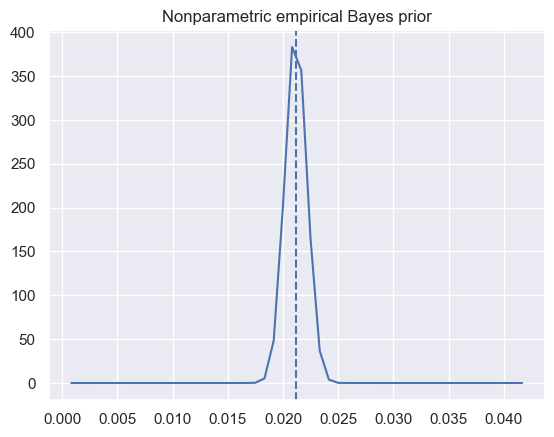

In [4]:
nonparametric_bayes_model = Nonparametric.from_results(results, columns=treatment_coefficients)
prior = nonparametric_bayes_model.get_marginal_prior(0)
lower, upper = prior.ppf(.025), prior.ppf(.975)
print("Prior 95% CI:", lower, upper)
ax = sns.lineplot(x=x, y=prior.pdf(x))
ax.axvline(prior.mean(), linestyle="--")
ax.set_title("Nonparametric empirical Bayes prior")
ax.set_xlim(xlim)
plt.show()

According to the nonparametric empirical Bayes prior, there's a 95% chance that each text message increases vaccination rates by between 1.9 and 2.3 people per hundred.

Notice that the nonparametric empirical Bayes prior is narrower than the parametric empirical Bayes prior. This is because the parametric empirical Bayes model accounts for uncertainty in our estimates of the prior parameters. By contrast, nonparametric empirical Bayes priors are often too narrow when estimating only a few treatment effects (in this case, 19). I typically prefer parametric empirical Bayes when estimating fewer than 50 treatment effects.

### Summary

In Bayesian analysis, we begin with a prior belief about our treatment effects. We then use data to update our belief according to Bayes' theorem. Our updated belief is called the *posterior*.

The key to good Bayesian analysis is a good prior belief. Classical Bayes takes the prior as a given. Empirical Bayes estimates a prior belief from the data. Parametric empirical Bayes assumes the shape of the prior distribution while nonparametric empirical Bayes does not. Nonparametric empirical Bayes is more flexible than parametric empirical Bayes, but often gives unrealistically narrow confidence intervals when estimating only a few parameters. My rough rule is to use parametric empirical Bayes when estimating fewer than 50 treatment effects.

## Why should I use Bayesian analysis?

Why use this fancy, complicated Bayesian analysis when you can use standard techniques like OLS? The short answer is that Bayesian estimators make better predictions of the true treatment effects than OLS. We can verify that Bayesian estimators are better using mathematical proofs, out-of-sample testing, and reconstruction plots.

First, let's look at the math. James and Stein (1961) proved that their empirical Bayes estimator *dominates* unbiased estimators like OLS. This means that the James-Stein estimator has a lower expected mean squared error than OLS, regardless of the true treatment effects.

Additionally, unbiased estimators like OLS exaggerate the variability of treatment effects. This fictitious variation makes it seem like treatment effects vary widely even if they do not. [Bayesian estimates "shrink" OLS estimates](https://kiwidamien.github.io/shrinkage-and-empirical-bayes-to-improve-inference.html), meaning that the posterior belief always falls between the OLS estimate and the prior. Bayesian estimators reduce and often eliminate fictitious variation by shrinking the OLS estimates.

A second way to verify that Bayesian estimators make better predictions than OLS is to use [out-of-sample testing](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). To understand out-of-sample testing, imagine we decide to run our experiment twice. After the first experiment, we get both Bayesian and OLS estimates. Then, we use these estimates to predict what will happen in the second experiment. After running the second experiment, we can see which estimator was better.

We may not be able to rerun our experiment, but we can simulate this process by splitting our data in half. We'll use one half of the data (the *training set* or *in-sample data*) to train our models and get Bayesian and OLS estimates. Then, we test how well these estimates matched the other half of the data (the *test set* or *out-of-sample data*).

How can we tell how well our estimates "matched" the test set? We're going to measure this using [log likelihood](https://en.wikipedia.org/wiki/Likelihood_function), a standard measure of goodness of fit measure. The test log-likelihood tells us how likely we are to observe the test set according to our estimates. The estimates that give us the highest test log-likelihood are the best.

Below, we repeat this splitting procedure many times to see how our Bayesian estimators stack up against OLS.

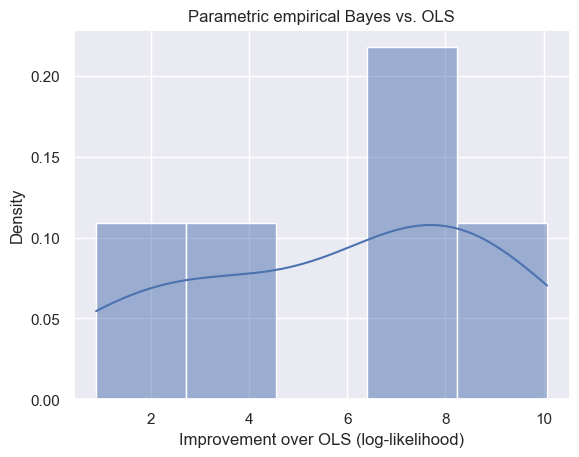

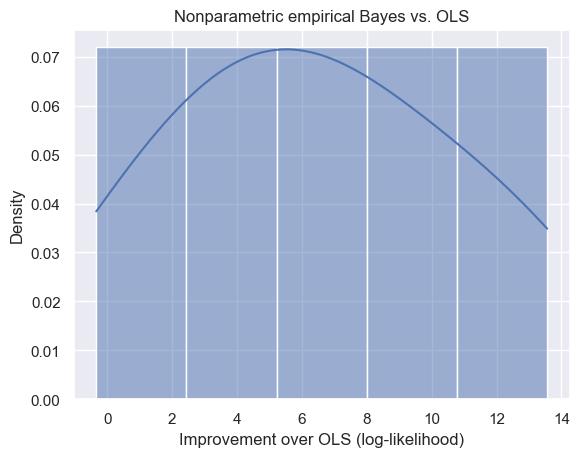

,Model,Mean test log likelihood
0,OLS,45.439741
1,Parametric empirical Bayes,51.271349
2,Nonparametric empirical Bayes,51.853948


In [6]:
def estimate_mean_and_covariance(index):
    # estimate the OLS means (point estimates) and covariance matrix
    X_subset, y_subset = X.iloc[index], df.vaccinated.iloc[index]
    results = sm.OLS(y_subset, X_subset).fit().get_robustcov_results()
    treatment_coefficients = [i for i, coefficient in enumerate(results.model.exog_names) if coefficient != "control"]
    return (
        results.params[treatment_coefficients],
        results.cov_params()[treatment_coefficients][:, treatment_coefficients]
    )


def compute_test_likelihood(train_mean, train_cov, test_mean, test_cov, model_cls):
    # train the model on the training data
    # then ask it to predict how likely we would be to observe the test data
    results = model_cls(train_mean, train_cov).fit()
    return results.likelihood(test_mean, test_cov)


def plot_improvement(bayes_test_likelihood, title):
    # plot how much the Bayesian model's test log likelihood improved upon OLS's test log likelihood
    improvement = np.log(bayes_test_likelihood) - np.log(ols_test_likelihood)
    ax = sns.histplot(x=improvement, kde=True, stat="density")
    ax.set_title(title)
    ax.set_xlabel("Improvement over OLS (log-likelihood)")
    return ax


ols_test_likelihood = []
parametric_bayes_test_likelihood = []
nonparametric_bayes_test_likelihood = []
kf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5)

for train_index, test_index in kf.split(df, df.treatment):
    train_mean, train_cov = estimate_mean_and_covariance(train_index)
    test_mean, test_cov = estimate_mean_and_covariance(test_index)

    ols_test_likelihood.append(
        compute_test_likelihood(
            train_mean, train_cov, test_mean, test_cov, Improper
        )
    )

    parametric_bayes_test_likelihood.append(
        compute_test_likelihood(
            train_mean, train_cov, test_mean, test_cov, Normal
        )
    )

    nonparametric_bayes_test_likelihood.append(
        compute_test_likelihood(
            train_mean, train_cov, test_mean, test_cov, Nonparametric
        )
    )

plot_improvement(parametric_bayes_test_likelihood, "Parametric empirical Bayes vs. OLS")
plt.show()

plot_improvement(nonparametric_bayes_test_likelihood, "Nonparametric empirical Bayes vs. OLS")
plt.show()

test_likelihoods = {
    "OLS": ols_test_likelihood,
    "Parametric empirical Bayes": parametric_bayes_test_likelihood,
    "Nonparametric empirical Bayes": nonparametric_bayes_test_likelihood
}
pd.DataFrame({
    "Model": test_likelihoods.keys(),
    "Mean test log likelihood": [np.log(test_likelihood).mean() for test_likelihood in test_likelihoods.values()]
})

Our out-of-sample analysis suggests that Bayesian estimators outperform OLS.

The third way to verify that Bayesian estimators are better than OLS is to look at reconstruction plots. Reconstruction plots are the most intuitive demonstration that Bayesian estimators are superior, although out-of-sample testing is more rigorous.

Reconstruction plots answer the following question: If these estimates are correct and we reran our experiment, how similar would the distribution of estimates in the second experiment be to the distribution of estimates in the original experiment (i.e., the experiment we actually ran)? Ideally, the distribution of estimates we would expect to see if we reran the experiment should match the distribution of estimates we saw in the original.

How do we get the distribution of estimates we would expect to see if we reran the experiment? Unfortunately, this question takes us into Ph.D.-level statistics territory, so I'll refer curious and ambitious readers to the [Wikipedia entry on Gibbs Sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) for more detail.

Below are reconstruction plots for the OLS and Bayesian estimators. The original estimates are the orange x's. The distribution of estimates we would expect to see if we reran the experiment is in blue. Ideally, the blue dots should overlap with the orange x's.

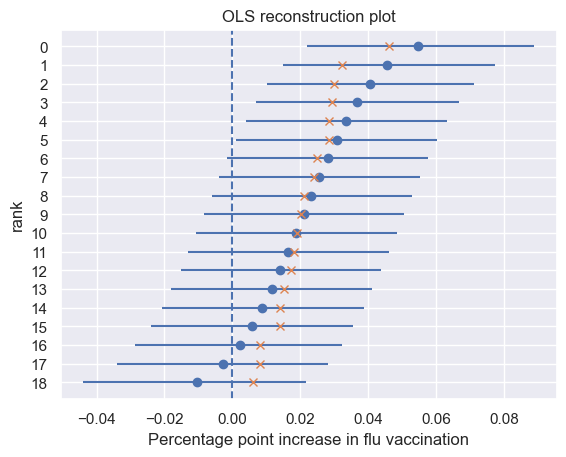

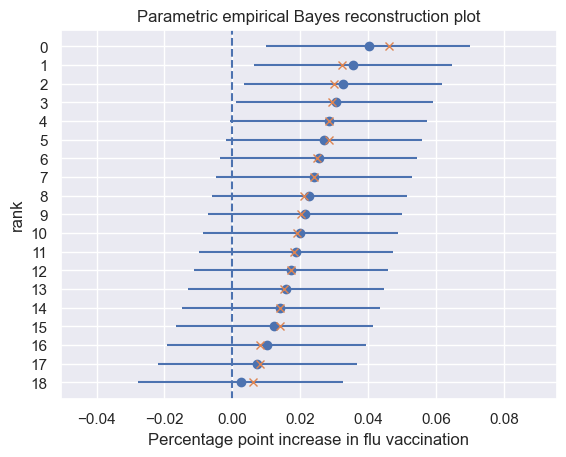

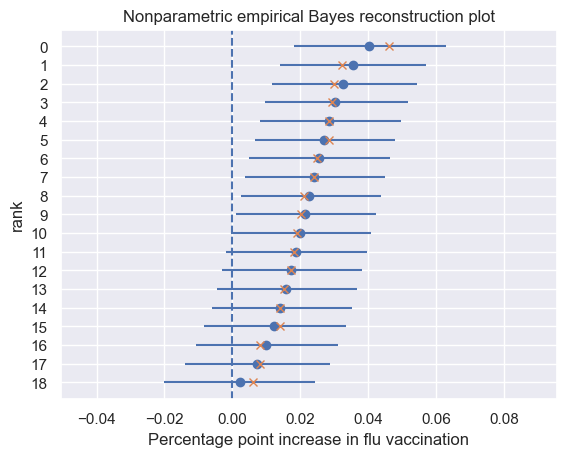

In [7]:
def make_reconstruction_plot(results, title=None, xlim=None):
    ax = results.reconstruction_point_plot(title=title)
    ax.set_xlabel(XLABEL)
    if xlim:
        ax.set_xlim(xlim)
    ax.axvline(0, linestyle="--")
    return ax


ols_reconstruction_plot = make_reconstruction_plot(ols_results, "OLS reconstruction plot")
xlim = ols_reconstruction_plot.get_xlim()
plt.show()

parametric_results = parametric_bayes_model.fit()
make_reconstruction_plot(parametric_results, title="Parametric empirical Bayes reconstruction plot", xlim=xlim)
plt.show()

nonparametric_results = nonparametric_bayes_model.fit()
make_reconstruction_plot(nonparametric_results, title="Nonparametric empirical Bayes reconstruction plot", xlim=xlim)
plt.show()

Notice the blue dots are more spread out than the orange x's in the OLS reconstruction plot. This confirms that OLS suffers from fictitious variation. By contrast, the blue dots are on top of the orange x's in the Bayesian reconstruction plots. This confirms that Bayesian estimators reliably estimate the distribution of treatment effects.

### Summary

Bayesian analysis is better than traditional techniques like OLS because it makes more accurate predictions of the true treatment effects. We verified this using mathematical proofs, out-of-sample testing, and reconstruction plots.

## How much can Bayesian analysis change my results?

Maybe you're thinking, "Okay, I'm convinced that Bayesian models are better than OLS, but how different are they? Maybe they'll shrink the OLS estimates slightly but is the difference significant? Can Bayesian estimators fundamentally change our understanding of scientific research?"

To understand the impact of Bayesian analysis, let's see how OLS and Bayesian estimates compare for our flu study. As a reminder, the common perception of this study's results, both in popular media and in academic circles, is that the ability of a text to increase vaccination rates critically depends on its phrasing. Fortune best sums up this perception.

> What they found was eye-opening. Precisely *how* a message was worded had a huge impact on whether the patient ended up getting the shot.

Now that we've verified that Bayesian estimators outperform OLS, let's plot the OLS and Bayesian results.

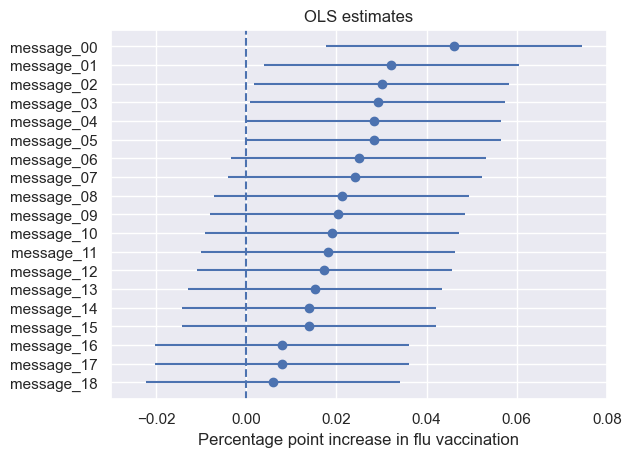

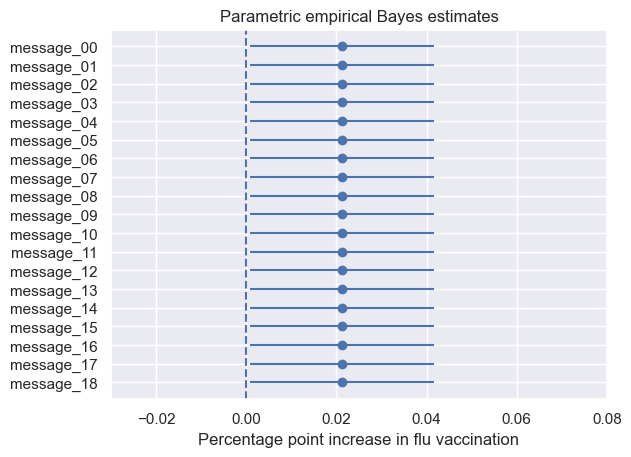

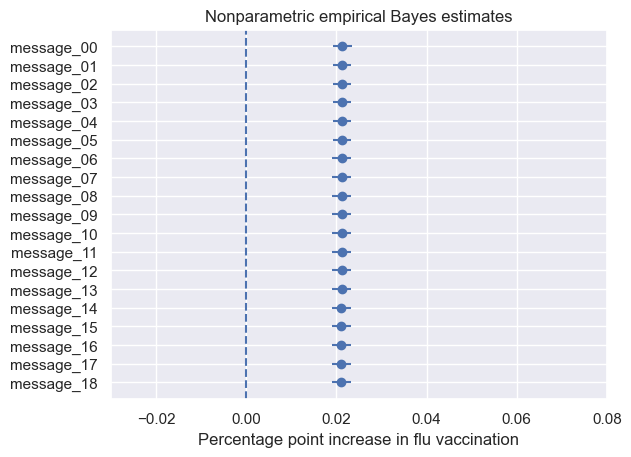

In [8]:
def point_plot(results, title=None):
    ax = results.point_plot(title=title)
    ax.set_xlabel(XLABEL)
    ax.set_xlim(XLIM)
    ax.axvline(0, linestyle="--")
    return ax


point_plot(ols_results, title="OLS estimates")
plt.show()

point_plot(parametric_results, title="Parametric empirical Bayes estimates")
plt.show()

point_plot(nonparametric_results, title="Nonparametric empirical Bayes estimates")
plt.show()

Looking at the OLS plot, we get the impression that we've identified certain text messages that outperform others. The Bayesian plots show us that this perception is incorrect. According to the Bayesian models, the treatment effects are indistinguishable.

Side note: Remember how we saw earlier that the nonparametric empirical Bayes prior was unrealistically narrow? The narrow prior leads to a narrow posterior (see the nonparametric empirical Bayes plot above). This is why parametric empirical Bayes is often better when analyzing only a few treatments.

According to OLS, the top-performing text message increases vaccination rates by 250 people in 10,000 compared to the average message. According to Bayes, the top-performing message increses vaccination rates by less than 1 person in 10,000.

In [9]:
print(
    "OLS: Increase in vaccination rates using the top performing treatment versus the average treatment:",
    10000 * (ols_results.params[0] - ols_results.params.mean()),
    "per 10,000"
)
print(
    "Bayes: Increase in vaccination rates using the top performing treatment versus the average treatment:",
    10000 * (parametric_results.params[0] - parametric_results.params.mean()),
    "per 10,000"
)

OLS: Increase in vaccination rates using the top performing treatment versus the average treatment: 248.1361967287397 per 10,000
Bayes: Increase in vaccination rates using the top performing treatment versus the average treatment: 4.688577921740933e-05 per 10,000


According to OLS, the phrasing matters tremendously. Our Bayesian models again show us that this picture is incorrect.

In sum, texting patients a reminder to get a flu vaccine boosts vaccination rates by about 2.1 people per hundred. Beyond the mere act of texting a reminder, there's no evidence that the phrasing of the text messages used in this study has a practically significant effect on vaccination rates.

## Conclusion

Bayesian analysis can significantly change our understanding of scientific research. We illustrated this by re-analyzing data from a highly-regarded study. Using Bayesian analysis, we showed that the study's original conclusion vastly overstated the effect of the top-performing treatment compared to the average treatment.

Congratulations for sticking with this primer until the end! We've explained how Bayesian analysis works, why you should use it, and how it can impact your results. To run Bayesian analysis on your own data, check out the file named `multiple_inference.ipynb` in this folder.